# AI Therapy Models - Group 8

# 1.Introduction

In 2025, generative AI has permeated nearly every sector, but one of its most transformative applications is in mental health therapy. According to a recent Harvard Business Review (HBR) study (Zao-Sanders, 2025), AI-powered therapy tools have emerged as the most common use case for generative AI, addressing the global shortage of mental health professionals and providing scalable, immediate support to those in need.

Our project explores the technical methodologies that enable AI therapy models to function effectively. We begin by selecting a base AI model (e.g., distilbert-base-uncased) and fine-tuning it for emotion recognition using specialized datasets like msba_ai_therapy_dataset. Next, we implement prompt engineering to guide the model’s responses in a clinically appropriate manner. Finally, we leverage the large language model Flan T5 Large to automatically craft emotionally supportive replies tailored to each detected emotional state.

*Figure 1 - Top 10 Gen AI Use Cases*

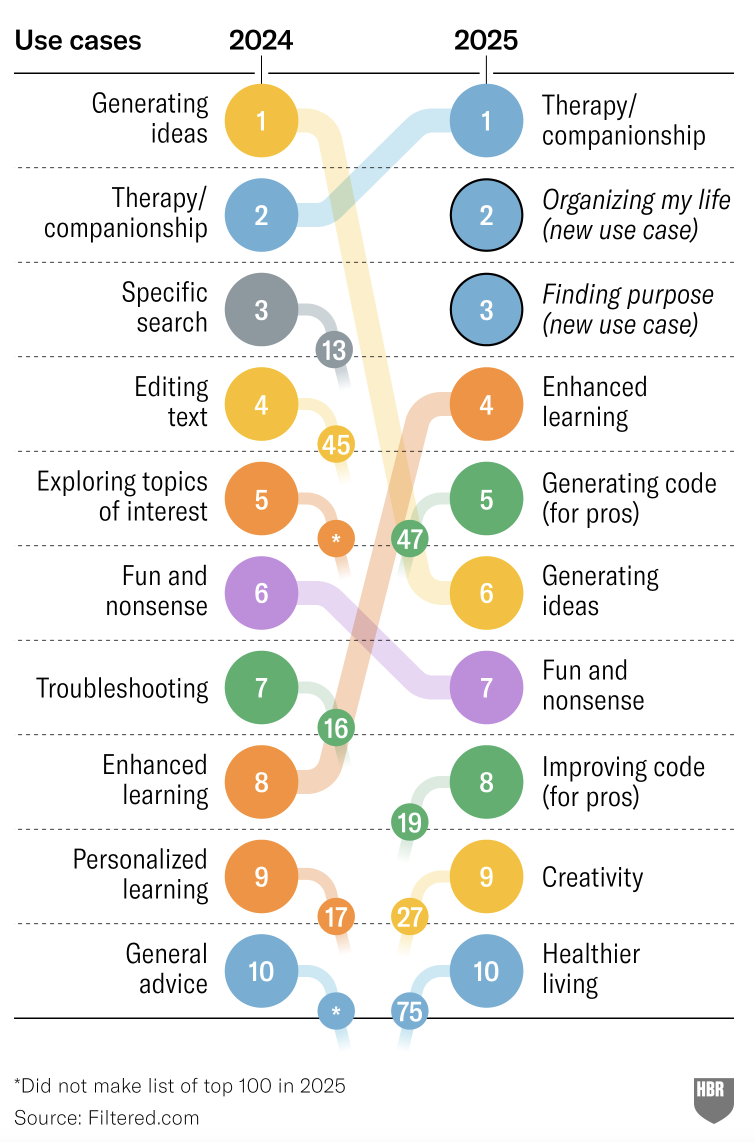

# 2.Core Techniques Powering AI Therapy Models:

Below, we outline the foundational methods enabling these systems, followed by a scenario illustrating their application for stressed MSBA students at Warwick Business School (WBS).

**Scenario: AI Therapy for Stressed MSBA Students**

**Context:**
* The Warwick MSBA cohort is working on their Generative AI group assignment under the guidance of course tutors Michael and Ram.

### 2.0 Environment Setup
Install tools and libraries needed to work with data, train the model, and check how well it performs. This model also requires a GPU to run.

In [1]:
# Step 1: Install required packages
!pip install -q transformers accelerate datasets peft scikit-learn

# Step 2: Import necessary libraries
import re, uuid, json, datetime, warnings  # Standard libraries for text processing, ID generation, date/time, and warning control
import pandas as pd  # For data handling and manipulation
import numpy as np
import matplotlib.pyplot as plt  # For plotting and visualization
from sklearn.model_selection import train_test_split  # To split dataset into training and validation
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix, ConfusionMatrixDisplay  # For performance metrics
from datasets import Dataset  # HuggingFace's dataset object for efficient processing
from transformers import (  # HuggingFace library for model loading and training
    AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments,
    Trainer, pipeline, EarlyStoppingCallback, AutoModelForSeq2SeqLM
)
from peft import get_peft_model, LoraConfig  # PEFT (Parameter-Efficient Fine-Tuning) utilities using LoRA
from IPython.display import display, Markdown  # For displaying formatted output in notebooks
import torch

warnings.filterwarnings("ignore")  # Ignore unnecessary warnings to reduce clutter

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 60.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 62.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

###2 .1. Emotion Detection with Zero-Shot Learning
**Code Purpose:**

This section uses Hugging Face’s zero-shot-classification pipeline with the model facebook/bart-large-mnli to detect emotional and mental health-related labels from user input.

In [2]:
# Emotion detection: zero-shot
zero_shot = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

# Define emotion and emotion risks labels
EMOTIONS_BASED_POSITIVE = {"joy"}
EMOTIONS_BASED_NEGATIVE_NO_RISK = {"sadness", "fear", "stress", "anger", "guilt", "shame", "disgust", "loneliness", "anxiety", "depression"}
MENTAL_HEALTH_NEGATIVE_HIGH_RISK = {"suicidal ideation", "homicidal ideation", "bipolar disorder", "PTSD", "self-harm", "substance abuse", "eating disorder"}

ALL_SITUATIONS = list(EMOTIONS_BASED_POSITIVE | EMOTIONS_BASED_NEGATIVE_NO_RISK | MENTAL_HEALTH_NEGATIVE_HIGH_RISK)

# Emotion risk detection: zero-shot
def detect_emotion_risk(text: str) -> str:
    lower = text.lower()
    if re.search(r"\b(i don'?t want to live|want to die|kill myself|end my life|i will jump|going to jump|goodbye letter)\b", lower):
        return "suicidal ideation"
    if re.search(r"\bkill.*(person|someone|them)\b", lower):
        return "homicidal ideation"
    if re.search(r"\b(cut myself|hurt myself|burn myself)\b", lower):
        return "self-harm"
    if re.search(r"\b(binge|purge|skip meals|throw up food)\b", lower):
        return "eating disorder"
    if re.search(r"\b(drink.*to cope|need alcohol|get high)\b", lower):
        return "substance abuse"
    if re.search(r"\b(flashbacks|reliving.*trauma|nightmares)\b", lower):
        return "ptsd"

    result = zero_shot(text, candidate_labels=ALL_SITUATIONS, hypothesis_template="This text indicates {}.")
    return result["labels"][0].lower()

config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cuda:0


In [3]:
# Example Output:
print(detect_emotion_risk("I want to die"))
print(detect_emotion_risk("I got a terrible mark from my exam. I feel so stressed."))

suicidal ideation
stress


### 2.2 Fine-Tuning with LoRA

**Code Purpose:**

This section fine-tunes a transformer model (distilbert-base-uncased) on a labeled mental health dataset to classify emotional states (e.g., sadness, PTSD) and risk levels (e.g., high-risk, positive).

**Dataset Overview:**

msba_ai_therapy_dataset.csv is purpose‑built around pressures and situations students commonly face. It captures emotional cues (e.g., stress, joy) and student‑relevant clinical concerns (e.g., self‑harm thoughts), each paired with risk labels to enable layered classification of both emotional tone and urgency in academic life.


In [4]:
# Load and fine-tune dataset
MODEL_NAME = "distilbert-base-uncased"
BART_NAME = "facebook/bart-large-mnli"

# Load dataset and define labels
RAW_URL = ("https://raw.githubusercontent.com/chhaowang/genai_assignment/refs/heads/main/msba_ai_therapy_dataset.csv")
df = pd.read_csv(RAW_URL)  # Load custom dataset from CSV

emotion_labels = [
    'PTSD', 'stress', 'sadness', 'anxiety', 'eating disorder',
    'joy', 'substance abuse', 'self-harm', 'suicidal ideation', 'loneliness'
]

risk_labels = ['negative-high-risk', 'negative-no-risk', 'positive']

# Fine-tuning DistilBERT model for therapy support
def preprocess_and_finetune(
    df: pd.DataFrame,
    label_col: str,
    label_list: list,
    output_dir: str,
    model_name: str = MODEL_NAME,
    peft_r: int = 16,
    epochs: int = 3,
    batch_size: int = 8
):
    df = df.copy()
    df["label_idx"] = df[label_col].apply(lambda x: label_list.index(x)) # Convert string labels to integer indices
    train_df, val_df = train_test_split(df, test_size=0.2, stratify=df[label_col], random_state=42) # Stratified train-test split

    train_ds = Dataset.from_pandas(train_df[["text", "label_idx"]].rename(columns={"label_idx": "labels"}))
    val_ds = Dataset.from_pandas(val_df[["text", "label_idx"]].rename(columns={"label_idx": "labels"}))

    tokenizer = AutoTokenizer.from_pretrained(model_name) # Load tokenizer for the base model

    def preprocess(examples):
        return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=128) # Tokenize text

    train_ds = train_ds.map(preprocess, batched=True)
    val_ds = val_ds.map(preprocess, batched=True)

    base_model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(label_list)) # Load base classification model
    lora_conf = LoraConfig( # LoRA configuration
        task_type="SEQ_CLS",
        r=peft_r,
        lora_alpha=32,
        lora_dropout=0.1,
        target_modules=["q_lin", "v_lin"]
    )

    model = get_peft_model(base_model, lora_conf)

    steps_per_epoch = len(train_df) // batch_size

    args = TrainingArguments( # Setup training parameters
        output_dir=output_dir,
        num_train_epochs=epochs,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        logging_dir="./logs",
        do_eval=True,
        eval_strategy="steps",
        logging_steps=steps_per_epoch,
        eval_steps=steps_per_epoch,
        save_steps=steps_per_epoch,
        save_total_limit=1,
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        greater_is_better=False
    )


    def compute_metrics(p): # Define evaluation metrics
        preds = p.predictions.argmax(-1)
        labels = p.label_ids
        prec, rec, f1, _ = precision_recall_fscore_support(labels, preds, average="weighted", zero_division=0)
        acc = accuracy_score(labels, preds)
        return {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1} # Return metrics

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_ds,
        eval_dataset=val_ds,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]  # Stop early if no improvement
    )

    trainer.train() # Train the model
    eval_result = trainer.evaluate()
    return eval_result, val_df, tokenizer, model, trainer

### 2.3 Dual Fine-Tuning for Emotion and Risk Classifiers

**Code Purpose:**

This section executes the preprocess_and_finetune() function twice to create two separate classifiers:

*   The **emotion classifier** captures emotional nuance (e.g., joy, PTSD).
*   The **risk classifier** categorizes inputs by urgency (positive, low-risk, high-risk).

Both models are fine-tuned using the same base dataset, but each targets a different label column: "emotion" and "emotion_risk", respectively.

**Why It Matters:**

Domain tuned DistilBERT grasps student specific stress vocabulary, delivers sharper emotion recognition with lightweight inference, enabling responsive, privacy friendly support tailored to academic mental health scenarios.




In [ ]:
# Fine-tune both emotion and risk classifiers
results_emotion, val_emotion_df, emo_tokenizer, emo_model, emo_trainer = preprocess_and_finetune(
    df, label_col="emotion", label_list=emotion_labels, output_dir="./emotion-finetuned")

results_risk, val_risk_df, risk_tokenizer, risk_model, risk_trainer = preprocess_and_finetune(
    df, label_col="emotion_risk", label_list=risk_labels, output_dir="./risk-finetuned"
)

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

### 2.4 Emotion classification and risk identification with fine tuned model

**Code Purpose:**

This function uses a fine-tuned transformer model to classify new user input into a predefined label set — either emotional states or risk categories — based on the model provided.

**Why It Matters:**

In real-world deployment, this function enables live classification of user inputs. By passing input text through the trained models, the system can instantly detect emotional states or flag high-risk conditions with a confidence score. This forms the core inference mechanism in an AI therapy pipeline.

In [ ]:
# Use fine-tuned model to classify new input
import torch

def fine_tuned_classify(text, tokenizer, model, label_list):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}  # Move inputs to model's device (CPU/GPU)
    with torch.no_grad():
        logits = model(**inputs).logits  # Get raw output from model
        probs = torch.nn.functional.softmax(logits, dim=-1)  # Convert logits to probability scores
    pred_idx = torch.argmax(probs, dim=-1).item()  # Pick the label with highest score
    return label_list[pred_idx], probs[0, pred_idx].item()  # Return predicted label and confidence

### 2.5 HITL (Human-In-The-Loop) Safety Net

**Code Purpose:**

This section introduces a HITL (Human-In-The-Loop) mechanism designed to log high-risk or uncertain AI predictions for manual review.

**Why It Matters:**

In therapeutic use cases, false positives or false negatives can have serious consequences. HITL integration acts as a fail-safe layer that brings a human reviewer into the loop when:

*	The model is unsure about its classification.
*	The user’s emotional state may require live intervention.

It also builds trust and accountability into the system, preventing complete reliance on automated outputs in high-stakes scenarios.







In [ ]:
# HITL (Human-In-The-Loop) support
REVIEW_QUEUE_PATH = "pending_reviews.json"

# Function to save flagged messages for review
def log_for_review(user_text, reply, emotion):
    entry = {
        "id": str(uuid.uuid4()), "timestamp": datetime.datetime.now().isoformat(),
        "user_text": user_text, "proposed_reply": reply,
        "emotion": emotion, "status": "pending"
    }
    try:
        with open(REVIEW_QUEUE_PATH, "r") as f: data = json.load(f)
    except FileNotFoundError:
        data = []
    data.append(entry)
    with open(REVIEW_QUEUE_PATH, "w") as f: json.dump(data, f, indent=2)  # Save to JSON for HITL interface

# Flag inputs that need human attention (safety net)
def needs_human_review(emotion, confidence):
    return emotion in MENTAL_HEALTH_NEGATIVE_HIGH_RISK or confidence < 0.6  # High risk or uncertain prediction

### 2.6 Prompt Engineering

**Code Purpose:**

This function creates emotion‑specific prompt templates that instruct a language model to answer students’ non‑critical negative feelings (sadness, stress) in a supportive yet non‑therapeutic tone.

**Why It Matters in AI Therapy:**


Prompt engineering allows precise control over tone, style, and intent of the AI’s response — which is critical in mental health settings.

This approach ensures:

* Responses are non-clinical and safe,

* Emotional context is acknowledged,

* Replies remain brief, warm, and action-oriented.

**Benefit:**

Prompt-based control is fast, flexible, and ideal for situations where models must handle emotionally sensitive but non-urgent user input. It acts as a middle ground between scripted replies and free-form generation.

In [ ]:
# Define prompts for each emotion in no risk

def get_negative_no_risk_prompt(emotion: str, user_text: str) -> str:
    prompts = {
        "sadness": (
            f"A Warwick MSBA student says:\n\"{user_text}\"\n\n"
            "You are an emotionally supportive assistant, not a therapist.\n"
            "Write a 3-4 sentence response that acknowledges their sadness in a warm, understanding tone.\n"
            "Example:\n"
            "It's okay to feel down — this program can be intense sometimes.\n"
            "Try to take a short walk or write down something that's been on your mind.\n"
            "You don’t have to be productive all the time — caring for yourself counts too."
        ),
        "shame": (
            f"A student in the MSBA program says:\n\"{user_text}\"\n\n"
            "Respond with compassion and encouragement. Let them know that making mistakes or feeling embarrassed is part of learning.\n"
            "Example:\n"
            "You might feel like you've failed, but that’s not true.\n"
            "Everyone makes mistakes — it's part of learning.\n"
            "Be kind to yourself the way you would to a friend.\n"
        ),
        "stress": (
            f"You're supporting a Warwick MSBA student under academic stress:\n\"{user_text}\"\n\n"
            "Your job is to emotionally support them, not solve the assignment.\n"
            "Example:\n"
            "I understand your feelings. Don't worry about the assignment or exam.\n"
            "Try eating some delicious food or chatting with your friends.\n"
            "You must achieve a good result.\n"
        ),
        "anxiety": (
            f"A Warwick MSBA student just shared:\n\"{user_text}\"\n\n"
            "Write a supportive, grounded response that starts by acknowledging their anxiety.\n"
            "Example:\n"
            "I know your heart might be racing and your mind full of worries.\n"
            "Try to take a deep breath and slowly count to five.\n"
            "A small step forward is still progress.\n"
        ),
        "guilt": (
            f"A student says:\n\"{user_text}\"\n\n"
            "Respond as a kind, emotionally supportive assistant.\n"
            "Example:\n"
            "It’s okay to feel bad about something, it shows you care.\n"
            "Try writing a message to yourself with understanding and forgiveness.\n"
            "You deserve support and compassion too.\n"
        ),
        "loneliness": (
            f"A Warwick MSBA student just said:\n\"{user_text}\"\n\n"
            "Respond with warmth and empathy. Let them know that feeling disconnected is common in intense academic programs.\n"
            "Example:\n"
            "It’s hard feeling disconnected in such a busy program.\n"
            "Maybe start by messaging a classmate or attending a group session.\n"
            "You're not invisible — your presence matters.\n"
        )
    }

    example_text = prompts.get(emotion, "")

    prompt = (
        f"{example_text}\n"
        f"Student says:\n\"{user_text}\"\n\n"
        f"Now, write a new supportive reply in a similar tone, specifically for this student.\n"
        f"Use 2–4 lines. Start with empathy, then offer a simple, encouraging action."
    )

    return prompt

### 2.7 Risk Mitigation Techniques

**Code Purpose:**

This section maps high-risk emotional states (e.g., suicidal ideation, self-harm) to predefined, supportive responses. Instead of using generative output, it returns scripted messages with empathy, crisis support details, and links to Warwick Wellbeing or Samaritans. A default fallback is also provided for unmatched cases.


**Why It Is Used in AI Therapy:**

Rule-based responses eliminate the risk of unsafe or hallucinated replies. In high-stakes situations, they ensure consistency, ethical care, and immediate escalation guidance. This approach reinforces trust and safety by providing structured, human-approved support where free-form generation could cause harm.


In [ ]:
# Define rule-based responses for high risk emotions. To control and stable the reply.

RULE_BASED_RESPONSES = {
    "suicidal ideation": (
        "I'm really sorry you're feeling this way. Please don’t go through this alone — your wellbeing is more important than any assignment or deadline.\n"
        "You can contact Samaritans at 116 123 (UK) or email: jo@samaritans.org.\n"
        "The University of Warwick also offers confidential support — you can book an appointment here: https://wellbeing.warwick.ac.uk/."
    ),

    "self-harm": (
        "If you’re feeling the urge to harm yourself, that’s a sign you need support, not judgment.\n "
        "The Warwick Wellbeing Team is here for you — even a short conversation might help ease the pressure.\n "
        "Consider booking time with someone you trust or reach out to wellbeing team through https://wellbeing.warwick.ac.uk/."
    ),

    "substance abuse": (
        "It sounds like you're using substances to cope, and that’s often a sign you're under immense stress.\n "
        "You're not alone — many students struggle with pressure in silence.\n "
        "Please reach out to Warwick’s Health Centre or student support for healthier coping strategies: https://warwick.ac.uk/services/wss/.\n"
        "Or call 024 7526 3418 for a doctor's appointment in Warwick Health Centre."
    ),

    "eating disorder": (
        "Struggling with food during stressful times is more common than you think, especially in a high-achieving program like MSBA.\n "
        "But you don’t have to manage this alone. Warwick offers wellbeing and nutrition support — start by contacting https://wellbeing.warwick.ac.uk/."
    ),

    "bipolar disorder": (
        "If you’ve been experiencing intense mood swings or changes in energy, it might help to track your emotions over time.\n "
        "You can talk to someone from the Warwick Mental Health and Wellbeing team to explore what you're experiencing: https://wellbeing.warwick.ac.uk/.\n "
        "You're not expected to figure this out on your own."
    ),

    "PTSD": (
        "If you’re reliving past trauma, please know that this isn’t your fault — and it can get better with the right support.\n "
        "Consider reaching out to someone trained in trauma support via Warwick Wellbeing Services: https://wellbeing.warwick.ac.uk/. \n "
        "For now, try grounding yourself: name 5 things you can see, 4 you can touch, 3 you can hear."
    ),

    "homicidal ideation": (
        "If you’re having thoughts of hurting someone, it's very important to get help immediately.\n "
        "This doesn’t make you a bad person — it means you’re overwhelmed and need urgent support. \n"
        "Please call emergency services (999 in the UK), or contact Warwick Campus Security or Crisis Team: 024 7652 2083 (non-emergency, 24hrs) / 024 7652 2222 (emergency, 24hrs)."
    )
}

DEFAULT_HIGH_RISK_RESPONSE = (
    "You're facing something really difficult, and you don’t have to carry it alone. \n"
    "Please consider contacting Warwick’s Wellbeing Support Services, your personal tutor, or a crisis helpline. \n"
    "You matter, and support is available — even now."
)

### 2.8 Empathetic Dialogue Generation

**Code Purpose:**

This section loads the instruction-tuned model google/flan-t5-large using Hugging Face’s pipeline for text2text-generation. The configuration allows controlled response generation with parameters such as temperature and top_p, designed to create short, supportive outputs in line with therapeutic prompts.

**Why It Is Used in AI Therapy:**

FLAN-T5 is optimized for instruction-based tasks, making it suitable for prompts like “respond with compassion.” This allows AI therapy systems to generate dynamic yet safe responses to non-critical emotional inputs.

In [ ]:
# LLM loading
MODEL_ID = "google/flan-t5-large"
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)
model     = AutoModelForSeq2SeqLM.from_pretrained(MODEL_ID)

gen = pipeline(
    "text2text-generation",
    model=model,
    tokenizer=tokenizer,
    device=-1,
    max_new_tokens=128,
    do_sample=True,
    temperature=0.7,
    top_p=0.95
)

# 3.Model Evaluation and Selection

**Overview**

We compared **fine tuned DistilBERT** against **zero shot BART MNLI**, revealing superior accuracy from targeted tuning.

**Bar‑Chart Findings**

As the charts show, DeBERTa edges BART across both dashboards. In emotion detection its precision, recall and F1 climb roughly eight, eighteen and seventeen points, capturing subtler signals. On risk triage DeBERTa again leads, particularly recall (0.79 vs 0.67), yielding stronger coverage of high stakes cases while maintaining comparable precision.

In [ ]:
# ---------- Prediction ----------
def predict_with_bart(texts, labels):
    bart_pipe = pipeline("zero-shot-classification", model=BART_NAME)
    return [bart_pipe(t, candidate_labels=labels)["labels"][0] for t in texts]

def predict_with_finetuned(texts, tokenizer, model, label_list):
    preds = []
    for t in texts:
        inputs = tokenizer(t, return_tensors="pt", truncation=True, padding=True)

        # Move inputs to the same device as the model
        inputs = {k: v.to(model.device) for k, v in inputs.items()}

        outputs = model(**inputs)
        pred_idx = outputs.logits.argmax(dim=1).item()
        preds.append(label_list[pred_idx])
    return preds

# Get predictions
bart_preds_emotion = predict_with_bart(val_emotion_df["text"].tolist(), emotion_labels)
deberta_preds_emotion = predict_with_finetuned(val_emotion_df["text"].tolist(), emo_tokenizer, emo_model, emotion_labels)

bart_preds_risk = predict_with_bart(val_risk_df["text"].tolist(), risk_labels)
deberta_preds_risk = predict_with_finetuned(val_risk_df["text"].tolist(), risk_tokenizer, risk_model, risk_labels)

### Visualizations

In [ ]:
# ---------- Draw a single overall‑score comparison ----------
def plot_overall_scores(y_true, y_pred_bart, y_pred_deberta, title=""):

    metric_names = ["Precision", "Recall", "F1"]

    # Compute macro‑averaged metrics (precision, recall, f1, _)
    bart_scores = precision_recall_fscore_support(
        y_true, y_pred_bart, average="weighted", zero_division=0
    )[:3]

    deberta_scores = precision_recall_fscore_support(
        y_true, y_pred_deberta, average="weighted", zero_division=0
    )[:3]

    # Bar positions
    x = np.arange(len(metric_names))
    bar_width = 0.35

    # Plot
    fig, ax = plt.subplots(figsize=(6, 4))

    # Store the bar objects for labeling
    bart_bars = ax.bar(x - bar_width / 2, bart_scores,    width=bar_width, label="BART")
    deberta_bars = ax.bar(x + bar_width / 2, deberta_scores, width=bar_width, label="DeBERTa")

    ax.set_ylim(0, 1)
    ax.set_xticks(x)
    ax.set_xticklabels(metric_names)
    ax.set_ylabel("Score")
    ax.set_title(title)
    ax.legend(loc="upper right")

    # Label the bars using the stored objects
    ax.bar_label(bart_bars, fmt="%.2f", padding=3)
    ax.bar_label(deberta_bars, fmt="%.2f", padding=3)

    plt.tight_layout()
    plt.show()

# ---------- Usage ----------
# Emotion overall chart
plot_overall_scores(
    val_emotion_df["emotion"].tolist(),   # ground truth
    bart_preds_emotion,                   # BART predictions
    deberta_preds_emotion,                # DeBERTa predictions
    title="Emotion – Overall Scores"
)

# Emotion‑Risk overall chart
plot_overall_scores(
    val_risk_df["emotion_risk"].tolist(), # ground truth
    bart_preds_risk,                      # BART predictions
    deberta_preds_risk,                   # DeBERTa predictions
    title="Emotion‑Risk – Overall Scores"
)

**Confusion‑Matrix Insights**

Confusion matrices echo previous findings. DeBERTa’s emotion grid forms a crisp diagonal, with slips limited to the sadness‑loneliness pair, whereas BART funnels PTSD, eating‑disorder, and substance‑abuse into “stress.” In risk triage, BART over‑flags no‑risk posts as high‑risk; DeBERTa cleanly isolates high‑risk but overlooks positives—model choice depends on acceptable error trade‑offs.

In [ ]:
# ---------- Draw Confusion Matrix ----------
def plot_confusion_matrices(y_true, y_pred_bart, y_pred_deberta, label_list, title_prefix=""):
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    cm_bart = confusion_matrix(y_true, y_pred_bart, labels=label_list)
    cm_deberta = confusion_matrix(y_true, y_pred_deberta, labels=label_list)

    disp_bart = ConfusionMatrixDisplay(confusion_matrix=cm_bart, display_labels=label_list)
    disp_deberta = ConfusionMatrixDisplay(confusion_matrix=cm_deberta, display_labels=label_list)

    disp_bart.plot(ax=axes[0], cmap="Blues", colorbar=False)
    disp_deberta.plot(ax=axes[1], cmap="Greens", colorbar=False)

    axes[0].set_title(f"{title_prefix} BART Confusion Matrix")
    axes[1].set_title(f"{title_prefix} DeBERTa Confusion Matrix")

    for ax in axes:
        plt.setp(ax.get_xticklabels(), rotation=70)

    plt.tight_layout()
    plt.show()

In [ ]:
# Comparsions between two models with confusion matrix
plot_confusion_matrices(
    val_emotion_df["emotion"].tolist(), bart_preds_emotion,
    deberta_preds_emotion, emotion_labels, title_prefix="Emotion"
)


plot_confusion_matrices(
    val_risk_df["emotion_risk"].tolist(), bart_preds_risk,
    deberta_preds_risk, risk_labels, title_prefix="Risk"
)

**Conclusion — Selecting DeBERTa for Emotion Classification**

DeBERTa’s sharper bars and clean diagonals make it the clear choice. Higher precision recall uncovers subtle anxiety, PTSD and self harm signals BART masks as stress, while still isolating high risk posts without excess flags. This balance of granularity and safety fits our mandate to deliver accurate, empathetic support for stressed MSBA students.

# 4.Result

## 4.1 Unified Emotion Risk Reply Engine

A fine tuned DeBERTa tags each message with an emotion and confidence, while a parallel head assigns a risk level. High risk labels (PTSD, self harm) trigger a fixed safety script; non critical negatives feed a tailored prompt to Flan T5 for empathic advice, and positive moods elicit a cheerful response. Ambiguous or low confidence cases get a neutral listening reply and are logged for human review. The function returns a JSON packet—emotion, confidence, risk, reply—for downstream use.context aware reply.

In [ ]:
# Step 9: Generate chatbot reply from classified emotion and risk
def generate_reply(user_text: str) -> dict:
    emotion, emo_conf = fine_tuned_classify(user_text, emo_tokenizer, emo_model, emotion_labels)
    risk, risk_conf = fine_tuned_classify(user_text, risk_tokenizer, risk_model, risk_labels)

    # High-risk: only based on assigned responses
    if emotion in MENTAL_HEALTH_NEGATIVE_HIGH_RISK:
        reply = RULE_BASED_RESPONSES.get(emotion, DEFAULT_HIGH_RISK_RESPONSE)
        emotion_risk = "negative-high-risk"

    # No-risk: use prompt + Flan-T5
    elif emotion in EMOTIONS_BASED_NEGATIVE_NO_RISK:

        prompt = get_negative_no_risk_prompt(emotion, user_text)
        reply_raw = gen(prompt)[0]["generated_text"]
        reply = reply_raw.replace(". ", ".\n")
        emotion_risk = "negative-no-risk"

    # Positive: Flan-T5
    elif emotion in EMOTIONS_BASED_POSITIVE:
        prompt = (
            f"You're chatting with a happy MSBA student at Warwick.\n"
            f"Reply in a cheerful, relaxed tone. Celebrate their good moment and encourage them to enjoy it or share it with others."
        )
        reply_raw = gen(prompt)[0]["generated_text"]
        reply = reply_raw.replace(". ", ".\n")
        emotion_risk = "positive"

    else:
        reply = (
            "I’m here to listen. If you’re not sure how you feel, that’s okay too. "
            "Sometimes just talking helps. You can keep typing whenever you’re ready."
        )
        emotion_risk = "unknown"

    if needs_human_review(emotion, emo_conf):
        log_for_review(user_text, reply, emotion)

    return {
        "emotion": emotion,
        "confidence": round(emo_conf, 3),
        "risk": risk,
        "reply": reply
    }

## 4.2 User Interface

A welcoming Markdown banner invites free text. After every input the console shows the detected emotion, risk tier, and AI reply in real time. Typing “exit” or “quit” ends the chat. The minimal interface emphasises transparent, supportive dialogue while exposing structured outputs for easy monitoring.

In [ ]:
display(Markdown("""
# -----Your Emotion Support-----

👋 **Hello**, you can type anything in the chatbox.
I'm your friend and here to help you. 💬
If you want to leave, just type **exit** or **quit**.
"""))

while True:
    user_input = input("\n🗣️ You: ")
    if user_input.lower() in {"exit", "quit"}:
        display(Markdown("🌈 **Hope you have a good day!**"))
        break

    result = generate_reply(user_input)

    display(Markdown(f"""
---

**🔍 Emotion:** `{result['emotion']}`
**⚠️ Risk Level:** `{result['risk']}`

**🤖 My Reply:**
> {result['reply']}

"""))

#5.Reference List

1. Google Research, 2023. FLAN-T5: Scaling Instruction-Finetuned Language Models. [online] Available at: https://huggingface.co/google/flan-t5-large.

2. Hugging Face, 2023. distilbert-base-uncased. [online] Available at: https://huggingface.co/distilbert-base-uncased.

3. Hugging Face, 2023. facebook/bart-large-mnli. [online] Hugging Face. Available at: https://huggingface.co/facebook/bart-large-mnli.

4. Hugging Face, 2023. j-hartmann/emotion-english-distilroberta-base. [online] Available at: https://huggingface.co/j-hartmann/emotion-english-distilroberta-base.

5. Wang, C., 2025. MSBA AI Therapy Dataset. [online] GitHub. Available at: https://github.com/chhaowang/genai_assignment.

6. Zao-Sanders, M., 2025. How People Are Really Using Gen AI in 2025. Harvard Business Review. [online] Available at: https://hbr.org/2025/04/how-people-are-really-using-gen-ai-in-2025.

